In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import gc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 2 group  / skincare data
df = pd.read_csv('/home/ubuntu/w266/skincare_2_group.csv')
df.columns = ['review_text', 'age_range']
# df = df.iloc[:1000]
df

,review_text,age_range
0,ve been using this as a primer as well as for ...,1
1,I don^t know how you can beat this...absorbs p...,1
2,"This oil comes out rich & lustrous, but provi...",1
3,I bought this after so many recommendations fr...,0
4,"To preface this, I^ve been a long time fan of ...",0
...,...,...
9995,This moisturizer has been amazing! I have horm...,0
9996,1 oz has 500 mg of CBD.. that^s a solid dosag...,1
9997,I really like the Perricone MD Essential Fx Ac...,1
9998,I wanted to like this product because of the r...,1


In [3]:
df.groupby('age_range').describe()

review_text         \
                count unique   
age_range                      
0                2231   2231   
1                7769   7769   

                                                                   
                                                         top freq  
age_range                                                          
0          I bought this after so many recommendations fr...    1  
1          ve been using this as a primer as well as for ...    1

In [4]:
# adding special tokens at the beginning and end of each sentence for BERT to work properly
reviews = df.review_text.values
reviews = ["[CLS] " + review + " [SEP]" for review in reviews]
age_range = df.age_range.values

In [5]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(review) for review in reviews]
print ("Tokenize the first review:")
print (tokenized_texts[0])

Tokenize the first review:
['[CLS]', 've', 'been', 'using', 'this', 'as', 'a', 'prime', '##r', 'as', 'well', 'as', 'for', 'skin', 'treatment', '.', 'it', 'leaves', 'my', 'complexion', 'glowing', 'and', 'the', 'texture', 'of', 'my', 'face', 'feels', 'so', ',', 'so', 'smooth', '.', 'my', 'make', 'up', 'goes', 'on', 'very', 'nicely', 'without', 'sm', '##ud', '##ging', '.', '\\', 'n', '\\', 'ni', 'see', 'results', 'after', 'a', 'few', 'weeks', 'of', 'using', 'the', 'product', '.', 'laughter', 'lines', 'look', 'thinner', 'and', 'have', 'less', 'depth', '.', 'my', 'skin', 'can', 'sometimes', 'have', 'slight', 'patches', 'of', 'uneven', 'skin', 'town', '.', 'i', 'feel', 'like', 'it', 'has', 'helped', 'even', 'if', 'out', '.', 'overall', 'i', '^', 'm', 'really', 'satisfied', 'and', 'would', 'e', '##qua', '##te', 'it', 'to', 'products', 'at', 'higher', 'price', 'points', '.', '\\', 'n', '\\', 'nr', '##ece', '##ive', '##d', 'this', 'compliment', '##ary', 'from', 'in', '##fl', '##uen', '##ster', 

In [6]:
# Maximum sequence length
MAX_LEN = 400

In [7]:
# check maximum sequence length of our data
real_max_len = 0
for i in tokenized_texts:
    iter_len = len(i)
    if real_max_len < iter_len:
        real_max_len = iter_len
    else:
        pass

real_max_len

560

In [8]:
%%time
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (537 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (560 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (545 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (516 > 512). Running this sequence through BERT will result in indexing errors


CPU times: user 254 ms, sys: 4.37 ms, total: 258 ms
Wall time: 255 ms


In [9]:
%%time
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

CPU times: user 81 ms, sys: 15.8 ms, total: 96.8 ms
Wall time: 94.9 ms


In [10]:
# input_ids
input_ids.shape

(10000, 400)

In [11]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [12]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, age_range, 
                                                            random_state=2018, test_size=0.33)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.33)

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [15]:
# Manage GPU memory
gc.collect()
torch.cuda.empty_cache()

In [16]:
%%time
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

CPU times: user 8.08 s, sys: 1.97 s, total: 10 s
Wall time: 10.2 s


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [17]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [18]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [21]:
# Manage GPU memory OOM
gc.collect()
torch.cuda.empty_cache()

In [22]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
#         print('step: ', step)
    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
#     print('validation_dataloader:  ', len(validation_dataloader))
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5434529288669131


Epoch:  33%|███▎      | 1/3 [23:25<46:50, 1405.14s/it]

Validation Accuracy: 0.7815151515151515
Train loss: 0.5405286721418153


Epoch:  67%|██████▋   | 2/3 [46:49<23:24, 1404.92s/it]

Validation Accuracy: 0.7815151515151515
Train loss: 0.540477630286964


Epoch: 100%|██████████| 3/3 [1:10:14<00:00, 1404.97s/it]

Validation Accuracy: 0.7815151515151515


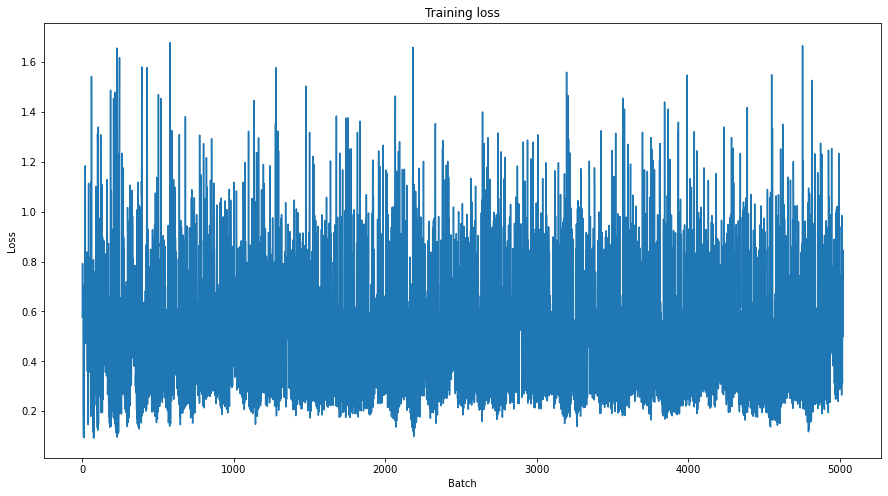

In [23]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

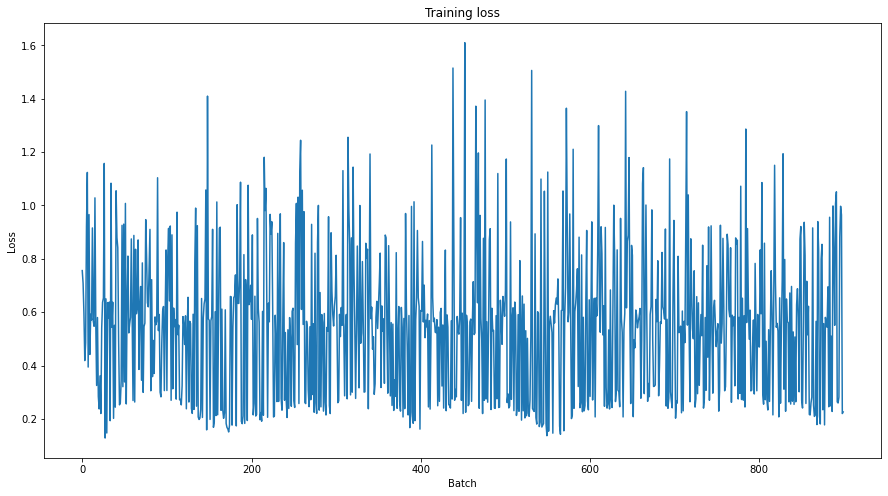

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [26]:

torch.cuda.empty_cache()

In [27]:
import GPUtil 
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 95% | 20% |
